# Predicting Soccer Injuries with Machine Learning
## Advanced Models

Jennifer Lawless    
DASC 9311: Data Science Project    
November 4, 2025

This notebook creates advanced models to predict injuries in soccer. The advanced models include LightGBM and SVM.

## Imports and Display Settings

In [95]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import warnings
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import sys
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import early_stopping

In [96]:
# Suppress warnings and set display styles:
warnings.filterwarnings('ignore')

# Set display options:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Reproducibility and GPU Configuration

In [97]:
# Define seeds for reproducibility:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

In [98]:
# Check if GPU is available (for environments that support it):
def check_gpu_available():
    """Check if GPU is available for different libraries"""
    gpu_info = {}
    
    # Check for CUDA:
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("NVIDIA GPU detected")
            gpu_info['cuda'] = True
        else:
            print("No NVIDIA GPU detected")
            gpu_info['cuda'] = False
    except FileNotFoundError:
        print("nvidia-smi not found - no NVIDIA GPU available")
        gpu_info['cuda'] = False
    
    return gpu_info

# Check and display GPU availability:
gpu_info = check_gpu_available()
print(f"\nGPU will be used where supported: {gpu_info['cuda']}\n")

NVIDIA GPU detected

GPU will be used where supported: True



## Data Loading

In [99]:
# Load the dataset:
df = pd.read_csv('data_prepped.csv')
df.head()

,Injury_Next_Season,Agility_Score,Balance_Test_Score,Fitness_Score,Hamstring_Flexibility,Knee_Strength_Score,Low_Fitness,Nutrition_Quality_Score,Previous_Injury_Count,Reaction_Time_ms,Sleep_Hours_Per_Night,Sprint_Speed_10m_s,Stress_Level_Score,Stress_Sleep_Ratio,Warmup_Routine_Adherence,Wellness_Score
0,0,-0.087649,1.069297,0.491996,-0.005236,0.379259,0,0.760997,-0.411816,1.560205,1.037465,-0.227881,-0.650428,-0.899441,1,1.127931
1,0,1.843613,0.500648,1.111952,0.502136,-0.346362,0,0.716401,0.475002,0.050595,1.979228,-0.468019,-0.409281,-0.982990,1,1.340729
2,1,-0.939707,-0.058566,-0.519264,-0.475015,0.319748,0,-1.020030,0.475002,0.876025,-0.237389,-0.667398,-0.955724,-0.741810,0,-0.023700
3,0,0.586842,0.543868,0.619538,-0.780880,1.183688,0,1.657432,-0.411816,-1.026915,0.333441,0.831162,-0.219940,-0.361847,1,1.022099
4,1,0.996011,-0.104356,0.394975,-0.369953,0.275898,0,-0.301841,0.475002,-0.909176,-0.870460,-1.725425,-0.145343,0.189340,0,-0.399246


## Model 4: LightGBM

### Model Development and Evaluation

In [100]:
# Configure GPU settings for LightGBM:
if gpu_info.get('cuda', False):
    device = 'gpu'
    print("LightGBM configured to use GPU")
else:
    device = 'cpu'
    print("LightGBM using CPU (no GPU detected)")

# Assign features and target variables:
X_lgb = df.drop(columns=['Injury_Next_Season'])
y_lgb = df['Injury_Next_Season']

# Define evaluation metrics:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Single cross-validation split for efficiency:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = cv  # Keep backward-compatible name used elsewhere in the notebook

# Train/validation split for early stopping:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_lgb, y_lgb, test_size=0.2, stratify=y_lgb, random_state=RANDOM_STATE
)

# Hyperparameter search space:
param_dist = {
    'num_leaves': randint(20, 128),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 130),
    'min_child_samples': randint(5, 100),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0.0, 1.0),
    'reg_lambda': uniform(0.0, 1.0)
}

# Define fit parameters for early stopping:
fit_params = {
    "eval_set": [(X_valid, y_valid)],
    "eval_metric": "f1",
    "callbacks": [early_stopping(stopping_rounds=30)]
}

# Randomized search with early stopping via fit_params:
rs = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=40,
    scoring='f1',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit using fit_params:
rs.fit(X_train, y_train, **fit_params)

# Use best model from search:
lgb = rs.best_estimator_

# Simple cross-validation:
cv_results_lgb = cross_validate(
    lgb, X_lgb, y_lgb,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

LightGBM configured to use GPU
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2574
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [101]:
# Summarize results:
print("Model 4: LightGBM Results:\n")
metrics_summary_lgb = {metric: np.mean(cv_results_lgb[f'test_{metric}']) for metric in scoring.keys()}
print("Nested Cross-Validation Results (mean across folds):")
for metric, score in metrics_summary_lgb.items():
    print(f"{metric.capitalize()}: {score:.3f}")

# Save the first fitted estimator (from fold 0):
best_model_lgb = cv_results_lgb['estimator'][0]
joblib.dump(best_model_lgb, 'lightgbm_model.joblib')

Model 4: LightGBM Results:

Nested Cross-Validation Results (mean across folds):
Accuracy: 0.948
Precision: 0.940
Recall: 0.957
F1: 0.948
Roc_auc: 0.988


['lightgbm_model.joblib']

### Mean Performance Metrics Across Folds

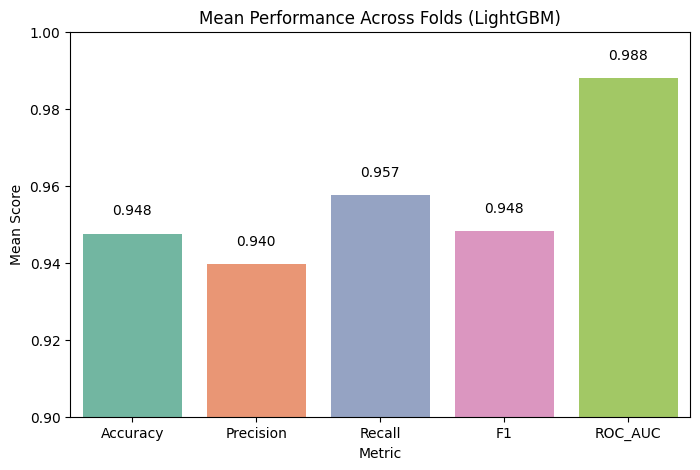

In [102]:
# Collect metrics from nested CV results
metrics_df_lgb = pd.DataFrame({
    'Accuracy': cv_results_lgb['test_accuracy'],
    'Precision': cv_results_lgb['test_precision'],
    'Recall': cv_results_lgb['test_recall'],
    'F1': cv_results_lgb['test_f1'],
    'ROC_AUC': cv_results_lgb['test_roc_auc']
})

# Create a bar chart of mean scores
mean_scores_lgb = metrics_df_lgb.mean().reset_index()
mean_scores_lgb.columns = ['Metric', 'Mean Score']

plt.figure(figsize=(8,5))
sns.barplot(data=mean_scores_lgb, x='Metric', y='Mean Score', palette="Set2")
plt.title("Mean Performance Across Folds (LightGBM)")
plt.ylim(0.9, 1.0)
for index, row in mean_scores_lgb.iterrows():
    plt.text(index, row['Mean Score'] + 0.005, f"{row['Mean Score']:.3f}", ha='center')
plt.show()

### Confusion Matrix

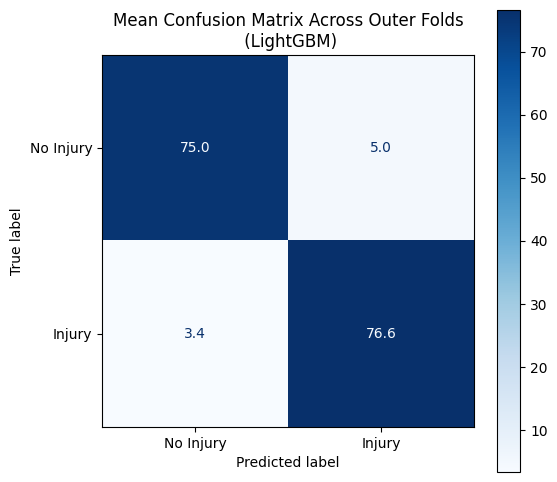

Mean Confusion Matrix:


,No Injury,Injury
No Injury,75.0,5.0
Injury,3.4,76.6


In [103]:
# Collect confusion matrices across outer folds
cms_lgb = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_lgb, y_lgb)):
    best_model = cv_results_lgb['estimator'][i]
    X_test, y_test = X_lgb.iloc[test_idx], y_lgb.iloc[test_idx]
    y_pred = best_model.predict(X_test)
    cms_lgb.append(confusion_matrix(y_test, y_pred))

# Average confusion matrix across folds
mean_cm_lgb = np.mean(cms_lgb, axis=0)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm_lgb,
                            display_labels=['No Injury', 'Injury'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', ax=ax, values_format=".1f")
plt.title("Mean Confusion Matrix Across Outer Folds\n (LightGBM)")
plt.show()

# Output the confusion matrix DataFrame
mean_cm_df_lgb = pd.DataFrame(mean_cm_lgb, index=['No Injury', 'Injury'], 
                            columns=['No Injury', 'Injury'])
print("Mean Confusion Matrix:")
display(mean_cm_df_lgb)

### Feature Importance

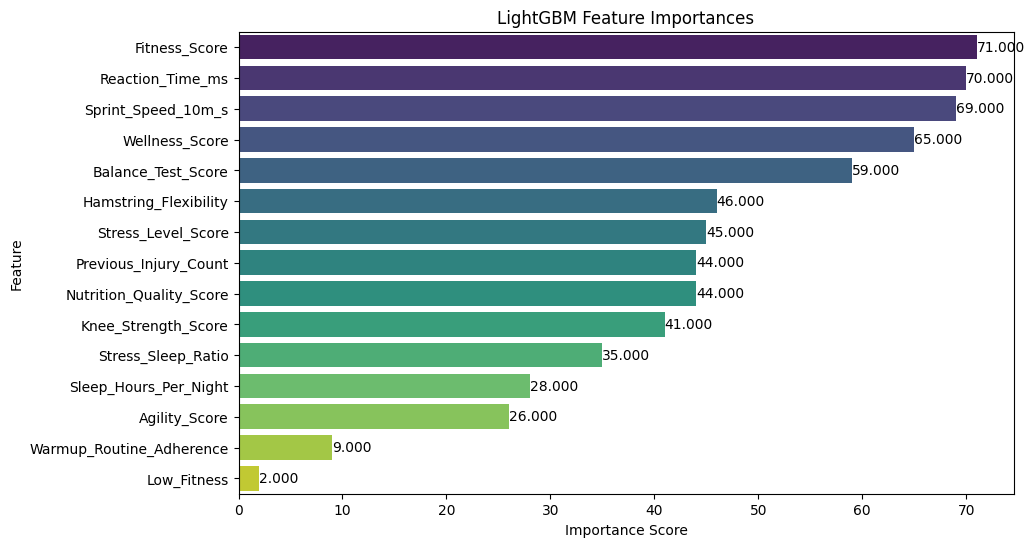

,Feature,Importance
0,Fitness_Score,71
1,Reaction_Time_ms,70
2,Sprint_Speed_10m_s,69
3,Wellness_Score,65
4,Balance_Test_Score,59
5,Hamstring_Flexibility,46
6,Stress_Level_Score,45
7,Previous_Injury_Count,44
8,Nutrition_Quality_Score,44
9,Knee_Strength_Score,41


In [104]:
# Extract feature importances from the last fitted model
best_model_lgb = cv_results_lgb['estimator'][-1]
importance_df_lgb = pd.DataFrame({
    'Feature': X_lgb.columns,
    'Importance': best_model_lgb.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df_lgb, x='Importance', y='Feature', palette="viridis")
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
for index, row in importance_df_lgb.iterrows():
    plt.text(row['Importance'], index, f"{row['Importance']:.3f}", ha='left', va='center')
plt.show()

# Output the importances DataFrame
display(importance_df_lgb)

### ROC Curves

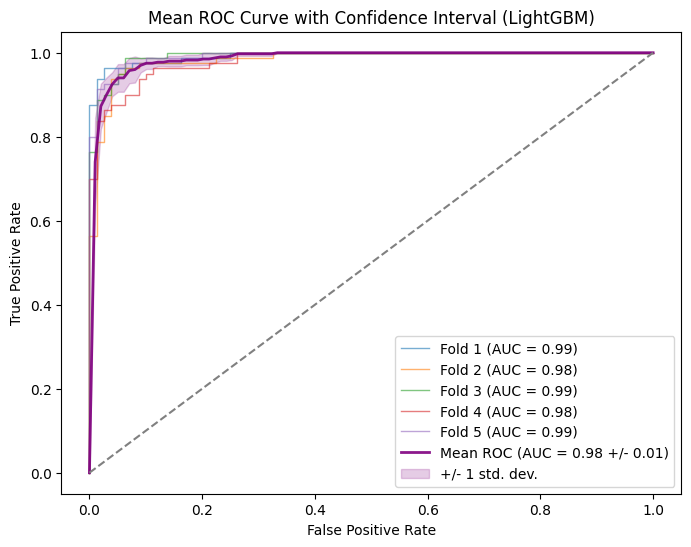

In [105]:
# Plot ROC curves for each fold and the mean ROC curve
tprs_lgb = []
aucs_lgb = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_lgb, y_lgb)):
    best_model = cv_results_lgb['estimator'][i]
    X_test, y_test = X_lgb.iloc[test_idx], y_lgb.iloc[test_idx]

    # Predict probabilities
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs_lgb.append(roc_auc)
    
    # Interpolate TPR
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs_lgb.append(tpr_interp)
    
    # Plot each fold
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

# Mean ROC
mean_tpr_lgb = np.mean(tprs_lgb, axis=0)
mean_tpr_lgb[-1] = 1.0
mean_auc_lgb = auc(mean_fpr, mean_tpr_lgb)
std_auc_lgb = np.std(aucs_lgb)

plt.plot(mean_fpr, mean_tpr_lgb, color='purple',
         label=f"Mean ROC (AUC = {mean_auc_lgb:.2f} +/- {std_auc_lgb:.2f})",
         lw=2, alpha=0.9)

# Confidence interval
tprs_std_lgb = np.std(tprs_lgb, axis=0)
tprs_upper_lgb = np.minimum(mean_tpr_lgb + tprs_std_lgb, 1)
tprs_lower_lgb = np.maximum(mean_tpr_lgb - tprs_std_lgb, 0)
plt.fill_between(mean_fpr, tprs_lower_lgb, tprs_upper_lgb, color='purple', alpha=0.2,
                 label='+/- 1 std. dev.')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("Mean ROC Curve with Confidence Interval (LightGBM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Model 5: Support Vector Machine (SVM)

### Model Development and Evaluation

In [106]:
# Select only raw features (exclude engineered features):
engineered_features = [
    'Fitness_Score', 'Wellness_Score', 'Workload_Recovery_Ratio',
    'Stress_Sleep_Ratio', 'Low_Fitness'
]

# Create dataset without engineered features for Random Forest:
df_raw = df.copy()
for feature in engineered_features:
    if feature in df_raw.columns:
        df_raw = df_raw.drop(columns=[feature])

In [112]:
# Assign features and target variables for SVM:
X_svm = df_raw.drop(columns=['Injury_Next_Season'])
y_svm = df_raw['Injury_Next_Season']

# Define the SVM model with good default parameters:
svm = SVC(
    random_state=RANDOM_STATE,
    probability=True,
    C=1.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced'
)

# Simple cross-validation:
cv_results_svm = cross_validate(
    svm, X_svm, y_svm,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# Summarize results:
print("Model 5: SVM Results\n")
metrics_summary_svm = {metric: np.mean(cv_results_svm[f'test_{metric}']) for metric in scoring.keys()}
print("Cross-Validation Results (mean across folds):")
for metric, score in metrics_summary_svm.items():
    print(f"{metric.capitalize()}: {score:.3f}")

# Select best model from CV folds based on F1 score:
best_index_svm = np.argmax(cv_results_svm['test_f1'])
best_model_svm = cv_results_svm['estimator'][best_index_svm]

# Predict on full data (or use a holdout set if preferred):
y_pred_svm = best_model_svm.predict(X_svm)
y_proba_svm = best_model_svm.predict_proba(X_svm)[:, 1]

# Final evaluation on full data:
accuracy_svm = accuracy_score(y_svm, y_pred_svm)
precision_svm = precision_score(y_svm, y_pred_svm)
recall_svm = recall_score(y_svm, y_pred_svm)
f1_svm = f1_score(y_svm, y_pred_svm)
roc_auc_svm = roc_auc_score(y_svm, y_proba_svm)

print("\nBest Fold Model Evaluation on Full Data:")
print(f"Accuracy: {accuracy_svm:.3f}")
print(f"Precision: {precision_svm:.3f}")
print(f"Recall: {recall_svm:.3f}")
print(f"F1 Score: {f1_svm:.3f}")
print(f"ROC-AUC: {roc_auc_svm:.3f}")

# Save the best performing model:
joblib.dump(best_model_svm, 'svm_model.joblib')

Model 5: SVM Results

Cross-Validation Results (mean across folds):
Accuracy: 0.946
Precision: 0.948
Recall: 0.945
F1: 0.946
Roc_auc: 0.988

Best Fold Model Evaluation on Full Data:
Accuracy: 0.970
Precision: 0.972
Recall: 0.968
F1 Score: 0.970
ROC-AUC: 0.994


['svm_model.joblib']

### Mean Performance Metrics Across Folds

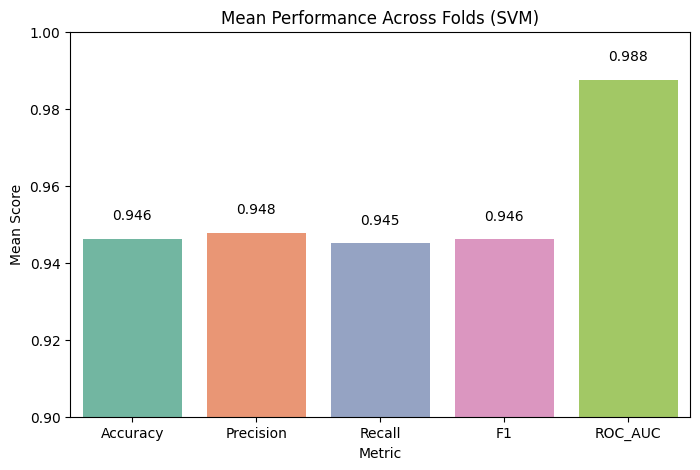

In [108]:
# Collect metrics from nested CV results
metrics_df_svm = pd.DataFrame({
    'Accuracy': cv_results_svm['test_accuracy'],
    'Precision': cv_results_svm['test_precision'],
    'Recall': cv_results_svm['test_recall'],
    'F1': cv_results_svm['test_f1'],
    'ROC_AUC': cv_results_svm['test_roc_auc']
})

# Create a bar chart of mean scores
mean_scores_svm = metrics_df_svm.mean().reset_index()
mean_scores_svm.columns = ['Metric', 'Mean Score']

plt.figure(figsize=(8,5))
sns.barplot(data=mean_scores_svm, x='Metric', y='Mean Score', palette="Set2")
plt.title("Mean Performance Across Folds (SVM)")
plt.ylim(0.9, 1.0)
for index, row in mean_scores_svm.iterrows():
    plt.text(index, row['Mean Score'] + 0.005, f"{row['Mean Score']:.3f}", ha='center')
plt.show()

### Confusion Matrix

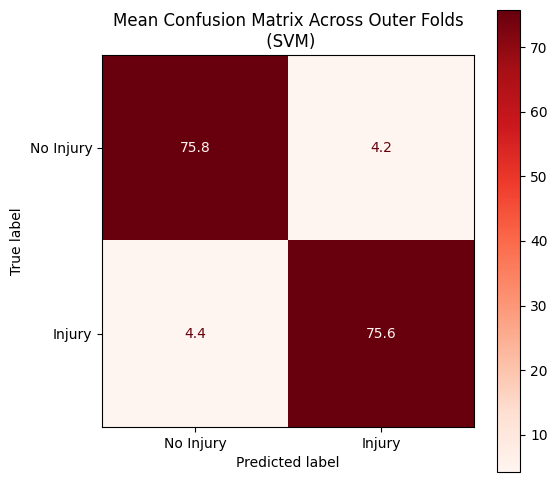

Mean Confusion Matrix:


,No Injury,Injury
No Injury,75.8,4.2
Injury,4.4,75.6


In [109]:
# Collect confusion matrices across outer folds
cms_svm = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_svm, y_svm)):
    best_model = cv_results_svm['estimator'][i]
    X_test, y_test = X_svm.iloc[test_idx], y_svm.iloc[test_idx]
    y_pred = best_model.predict(X_test)
    cms_svm.append(confusion_matrix(y_test, y_pred))

# Average confusion matrix across folds
mean_cm_svm = np.mean(cms_svm, axis=0)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm_svm,
                            display_labels=['No Injury', 'Injury'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Reds', ax=ax, values_format=".1f")
plt.title("Mean Confusion Matrix Across Outer Folds\n (SVM)")
plt.show()

# Output the confusion matrix DataFrame
mean_cm_df_svm = pd.DataFrame(mean_cm_svm, index=['No Injury', 'Injury'], 
                            columns=['No Injury', 'Injury'])
print("Mean Confusion Matrix:")
display(mean_cm_df_svm)

### ROC Curves

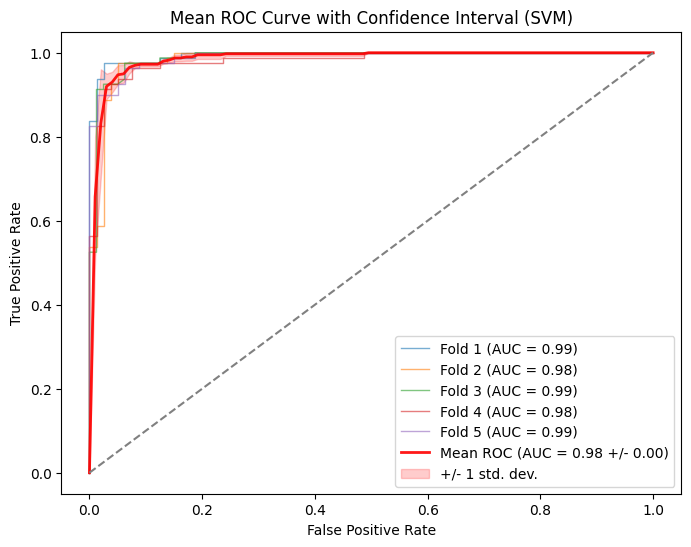

In [110]:
# Plot ROC curves for each fold and the mean ROC curve
tprs_svm = []
aucs_svm = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_svm, y_svm)):
    best_model = cv_results_svm['estimator'][i]
    X_test, y_test = X_svm.iloc[test_idx], y_svm.iloc[test_idx]

    # Predict probabilities
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs_svm.append(roc_auc)
    
    # Interpolate TPR
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs_svm.append(tpr_interp)
    
    # Plot each fold
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

# Mean ROC
mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_tpr_svm[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr_svm)
std_auc_svm = np.std(aucs_svm)

plt.plot(mean_fpr, mean_tpr_svm, color='red',
         label=f"Mean ROC (AUC = {mean_auc_svm:.2f} +/- {std_auc_svm:.2f})",
         lw=2, alpha=0.9)

# Confidence interval
tprs_std_svm = np.std(tprs_svm, axis=0)
tprs_upper_svm = np.minimum(mean_tpr_svm + tprs_std_svm, 1)
tprs_lower_svm = np.maximum(mean_tpr_svm - tprs_std_svm, 0)
plt.fill_between(mean_fpr, tprs_lower_svm, tprs_upper_svm, color='red', alpha=0.2,
                 label='+/- 1 std. dev.')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("Mean ROC Curve with Confidence Interval (SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()